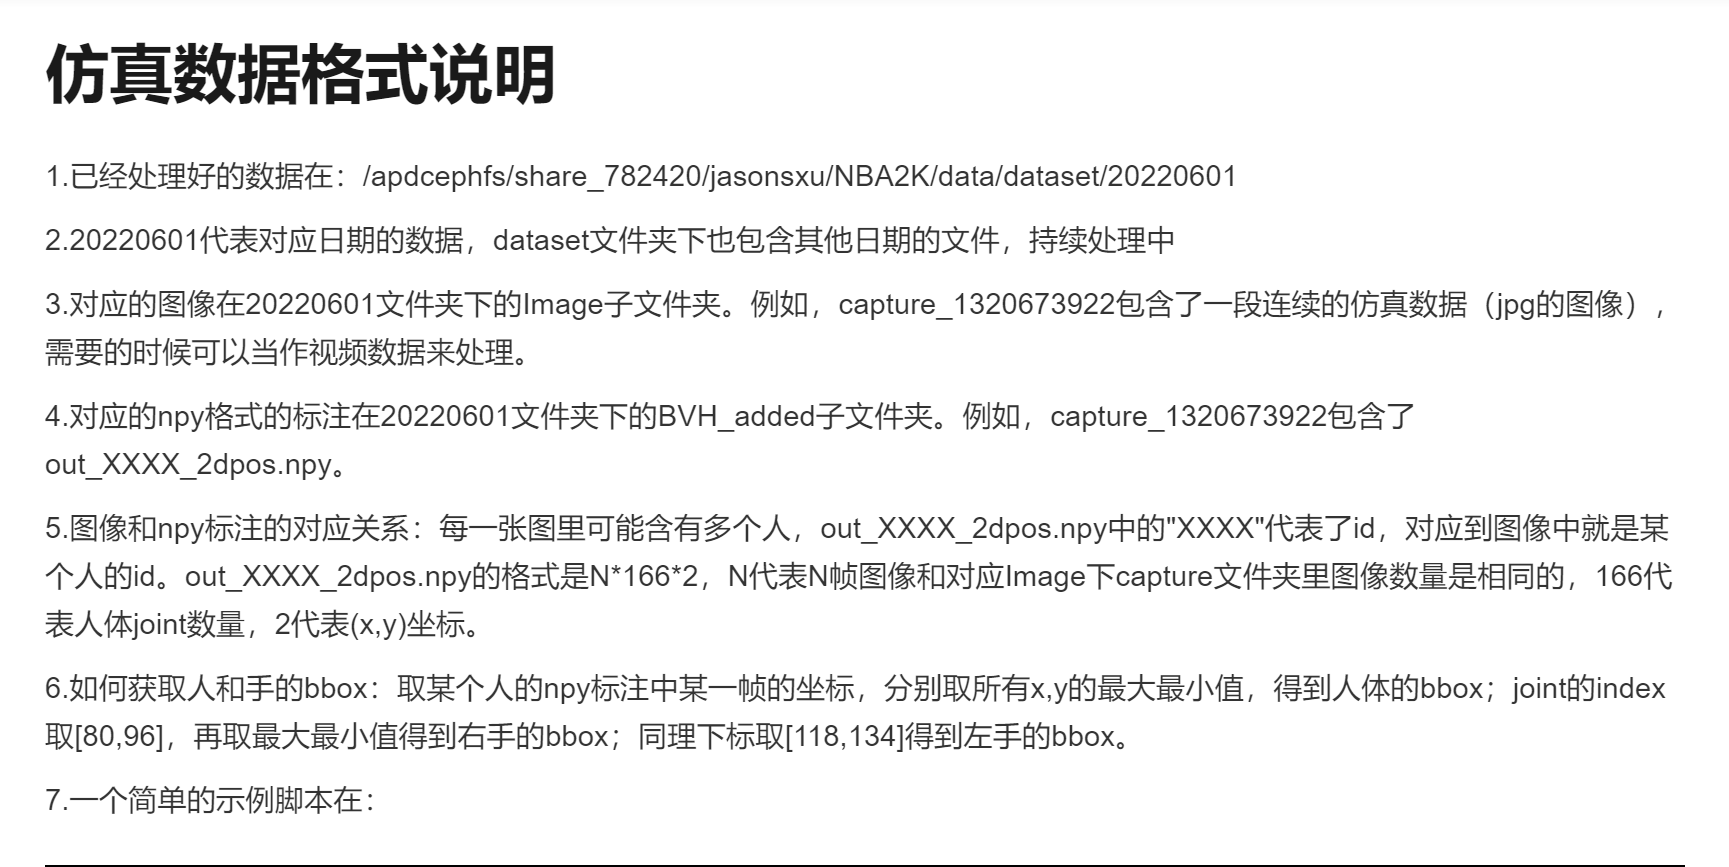

# 仿真数据生成coco数据集labels

* data_path: 仿真数据生成日期对应文件夹
* debug：是否展示数据，展示为debug = True
* e.g.
```
data_path = '/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111'
debug = False


In [1]:
# import torch
import os
import sys
import numpy as np
from pathlib import Path
from tqdm import tqdm

In [6]:
os.system('pwd')

/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/BVH_added/capture_1066087968


0

In [2]:
import numpy as np
import cv2 as cv2

date = "20220601"
videoid = "capture_1320673922"
personid = "out_4484_2dpos.npy"
frameid = 50

img = cv2.imread("/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/%s/Image/%s/capture_%08d.jpg" % (date, videoid, frameid))
pose2ds = np.load("/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/%s/BVH_added/%s/%s" % (date, videoid, personid))
pose2d = pose2ds[frameid]
##get person bbox
minx0, miny0, maxx0, maxy0 = np.min(pose2d[:, 0]), np.min(pose2d[:, 1]), np.max(pose2d[:, 0]), np.max(pose2d[:, 1])
##get left hand bbox
minx1, miny1, maxx1, maxy1 = np.min(pose2d[80:97, 0]), np.min(pose2d[80:97, 1]), np.max(pose2d[80:97, 0]), np.max(pose2d[80:97, 1])
##get right hand bbox
minx2, miny2, maxx2, maxy2 = np.min(pose2d[118:135, 0]), np.min(pose2d[118:135, 1]), np.max(pose2d[118:135, 0]), np.max(pose2d[118:135, 1])
print(minx0, miny0, maxx0, maxy0, minx1, miny1, maxx1, maxy1, minx2, miny2, maxx2, maxy2)


300.78893736850125 177.07808819459757 365.3719722342096 318.26673033258254 351.8053597711512 224.7365631726242 365.3719722342096 234.4119983225878 334.3946079742544 215.45964256487184 349.78581136912874 221.8091288546293


In [3]:
total_sum = 0
for file in os.listdir('/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220601/BVH_added/capture_1320673922'):
    if file.split('_')[-1] == 'valid.npy':
        data = np.load(os.path.join('/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220601/BVH_added/capture_1320673922',file))
        total_sum += sum(data)
print(total_sum)

0


In [4]:
def generate_hand_bbox(pose2d, img_size, img, debug = False):
    ##get left hand bbox
    minx1, miny1, maxx1, maxy1 = np.min(pose2d[80:97, 0]), np.min(pose2d[80:97, 1]), np.max(pose2d[80:97, 0]), np.max(pose2d[80:97, 1])
    ##get right hand bbox
    minx2, miny2, maxx2, maxy2 = np.min(pose2d[118:135, 0]), np.min(pose2d[118:135, 1]), np.max(pose2d[118:135, 0]), np.max(pose2d[118:135, 1])
    if debug:
        cv2.rectangle(img, ( int(min(minx1, minx2)), int(min(miny1, miny2))), (  int(max(maxx1, maxx2)),int( max(maxy1, maxy2)) ), (0, 255, 0), 4)
    minx = min(minx1, minx2) / img_size[0]
    miny = min(miny1, miny2) / img_size[1]
    maxx = max(maxx1, maxx2) / img_size[0]
    maxy = max(maxy1, maxy2) / img_size[1]
    return f'{minx} {miny} {maxx} {maxy}\n'


def write_labels(out_labels_path, video_path, person_id_list, pose2ds_map_id2pose, id_prefix = 1, debug = False):
    if debug:
        print(f'cnt of persons is {len(person_id_list)}')
    frame_cnt = list(pose2ds_map_id2pose.values())[0].shape[0]
    img_name = f'capture_{"%08d" % (1)}.jpg'
    img_path = os.path.join(video_path, img_name)
    img = cv2.imread(img_path)
    img_size = img.shape[:2]
    if debug:
        print(img_size)
    
    for frame_id in tqdm(range(frame_cnt)):
        label_file_name = f'{id_prefix}_{"%08d" % (frame_id)}.txt'
        if debug:
            print(label_file_name)
        img_name = f'capture_{"%08d" % (1)}.jpg'
        img_path = os.path.join(video_path, img_name)
        img = cv2.imread(img_path)
        img_size = img.shape[:2]
        if debug:
            orignal_img = img.copy()
        
        with open(os.path.join(out_labels_path, label_file_name), 'w') as file:
            for person_id in person_id_list:
                pose2ds = pose2ds_map_id2pose[person_id]
                hand_bbox = generate_hand_bbox(pose2ds[frame_id], img_size, img, debug)
#                 if debug:
#                     img = orignal_img.copy()
#                     plt.figure()
#                     plt.title(person_id)
#                     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                file.write(str(1)+ ' ')
                file.write(str(hand_bbox))
        if debug:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if frame_id > 0:
                break
        


# 0/1  百分比分辨率
def generate_labels_of_coco(src_path, video_path, out_labels_path, debug = False):
    os.chdir(src_path)
    files_list = os.listdir(src_path)
    id_prefix = video_path.split('_')[-1]
    person_id_list = []
    pose2ds_map_id2pose = {}
    for file in files_list:
        if file.split('.')[-1] == 'bvh':
            person_id = file.split('_')[-1].split('.')[0]
            if person_id.isdigit():
                person_id_list.append(person_id)
    for person_id in person_id_list:
#         print(f'cnt of persons is {len(person_id_list)}')

        data_file = f'{person_id}_2dpos.npy'
        os.path.abspath(data_file)
        pose2ds = np.load(data_file)
        pose2ds_map_id2pose[person_id] = pose2ds
        if debug:
            print(pose2ds.shape)
    write_labels(out_labels_path, video_path,  person_id_list, pose2ds_map_id2pose, id_prefix, debug)
        



In [5]:
data_path = '/apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111'
debug = False
for video in os.listdir(os.path.join(data_path, 'BVH_added/')):
    print(video)
    src_path =  os.path.join(data_path, 'BVH_added', video)
    video_path = os.path.join(data_path, 'Image', video)
    out_labels_path = os.path.join(data_path, 'labels')
    os.makedirs(out_labels_path, exist_ok=True)
    print(f'generate labels of {video_path}')
    generate_labels_of_coco(src_path, video_path, out_labels_path, debug)


capture_1119132578
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1119132578


100%|████████████████████████████████████████████████████████████████████████████████| 2508/2508 [03:50<00:00, 10.90it/s]


capture_1118818828
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1118818828


100%|████████████████████████████████████████████████████████████████████████████████| 2531/2531 [03:10<00:00, 13.31it/s]


capture_1139715484
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1139715484


100%|████████████████████████████████████████████████████████████████████████████████| 2471/2471 [02:28<00:00, 16.67it/s]


capture_1137641750
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1137641750


100%|████████████████████████████████████████████████████████████████████████████████| 2423/2423 [02:26<00:00, 16.54it/s]


capture_1141128218
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1141128218


100%|████████████████████████████████████████████████████████████████████████████████| 2895/2895 [05:43<00:00,  8.43it/s]


capture_1138321328
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1138321328


100%|████████████████████████████████████████████████████████████████████████████████| 2737/2737 [05:25<00:00,  8.40it/s]


capture_1065256500
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1065256500


100%|████████████████████████████████████████████████████████████████████████████████| 2650/2650 [05:19<00:00,  8.30it/s]


capture_1141725296
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1141725296


100%|████████████████████████████████████████████████████████████████████████████████| 2627/2627 [05:19<00:00,  8.21it/s]


capture_1140293453
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1140293453


100%|████████████████████████████████████████████████████████████████████████████████| 2723/2723 [05:20<00:00,  8.49it/s]


capture_1136844125
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1136844125


100%|████████████████████████████████████████████████████████████████████████████████| 2970/2970 [05:56<00:00,  8.33it/s]


capture_1064350031
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1064350031


100%|████████████████████████████████████████████████████████████████████████████████| 2486/2486 [05:02<00:00,  8.21it/s]


capture_1120354750
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1120354750


100%|████████████████████████████████████████████████████████████████████████████████| 3011/3011 [06:11<00:00,  8.10it/s]


capture_1117974015
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1117974015


100%|████████████████████████████████████████████████████████████████████████████████| 2542/2542 [05:09<00:00,  8.21it/s]


capture_1133099843
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1133099843


100%|████████████████████████████████████████████████████████████████████████████████| 2287/2287 [04:35<00:00,  8.31it/s]


capture_1117262625
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1117262625


100%|████████████████████████████████████████████████████████████████████████████████| 2056/2056 [04:05<00:00,  8.37it/s]


capture_1139081875
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1139081875


100%|████████████████████████████████████████████████████████████████████████████████| 2548/2548 [05:11<00:00,  8.17it/s]


capture_1066087968
generate labels of /apdcephfs/share_782420/jasonsxu/NBA2K/data/dataset/20220111/Image/capture_1066087968


100%|████████████████████████████████████████████████████████████████████████████████| 2584/2584 [05:10<00:00,  8.33it/s]


In [7]:
from memory_profiler import profile
import psutil
print('used : %.2f MB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024))


used : 103.52 MB
